## Code Implemented

### Install Required Dependencies

In [2]:
!pip install -r requirements.txt

### Import Libraries

In [1]:
# External imports
import numpy as np
import time
import tdmclient.notebook

# Internal imports
from scripts.vision import Vision
from scripts.global_navigation import GlobalNav
from scripts.local_navigation import LocalNav
from scripts.extended_kalman_filter import ExtendedKalmanFilter
from utils import utils

### General Configuration

In [12]:
# Time step configuration
DT = 0.1  # s

# Webcam configuration
DEVICE_ID = 2

# World configuration
WORLD_WIDTH = 1060  # mm
WORLD_HEIGHT = 710 # mm

# Thymio configuration
THYMIO_WIDTH = 110  # mm
THYMIO_LENGTH = 110  # mm$
THYMIO_WHEEL_BASE = 90  # mm
THYMIO_WHEEL_RADIUS = 20  # mm
SPEED_TO_MM_S = 1.3 # Found experimentally (cf run_tests.ipynb)

# Kidnapping configuration
KIDNAP_THRESHOLD = 40 # mm

In [4]:
await tdmclient.notebook.start()
print("Successfully connected to Thymio.")

Successfully connected to Thymio.


In [5]:
@tdmclient.notebook.sync_var
def set_speed(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal.copy()

@tdmclient.notebook.sync_var
def get_speed():
    global motor_left_speed, motor_right_speed
    return motor_left_speed, motor_right_speed

print("Thymio functions defined correctly.")

Thymio functions defined correctly.


In [6]:
set_speed(100, 100)
time.sleep(1)
motor_stop()

In [7]:
vision = Vision(DEVICE_ID)
global_nav = GlobalNav()
local_nav = LocalNav()
ekf = ExtendedKalmanFilter(DT, THYMIO_WHEEL_BASE)

Vision initialized correctly.
GlobalNav initialized correctly.
LocalNav initialized correctly.
EKF initialized correctly.


In [8]:
try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
    start_time = time.time()
    while time.time() - start_time < 3:
        original_frame = vision._get_original_frame()
        utils.display_frames(original_frame, None, None)
except KeyboardInterrupt:
    pass
finally:
    vision.disconnect_webcam()

Webcam disconnected correctly.


Webcam disconnected correctly.

=== Obstacles Information ===
Number of obstacles detected: 3
Obstacle coordinates [mm]:

Obstacle 1:
    Corner 1: [598.4, 381.4]
    Corner 2: [512.2, 453.8]
    Corner 3: [562.7, 511.2]
    Corner 4: [648.9, 437.9]

Obstacle 2:
    Corner 1: [292.3, 128.8]
    Corner 2: [261.6, 239.8]
    Corner 3: [325.0, 269.5]
    Corner 4: [403.2, 181.3]

Obstacle 3:
    Corner 1: [585.5, 111.0]
    Corner 2: [602.4, 216.0]
    Corner 3: [685.6, 208.1]

=== Thymio Information ===
Position [mm]: [94.1, 479.5]
Orientation [°]: -15.2

=== Goal Information ===
Position [mm]: [872.8, 117.9]

=== Trajectory Information ===
Number of waypoints: 4
Waypoint path [mm]:
Checkpoint 1: [544.1, 315.1]
Checkpoint 2: [629.0, 270.6]
Checkpoint 3: [789.0, 258.4]
Checkpoint 4: [872.8, 117.9]


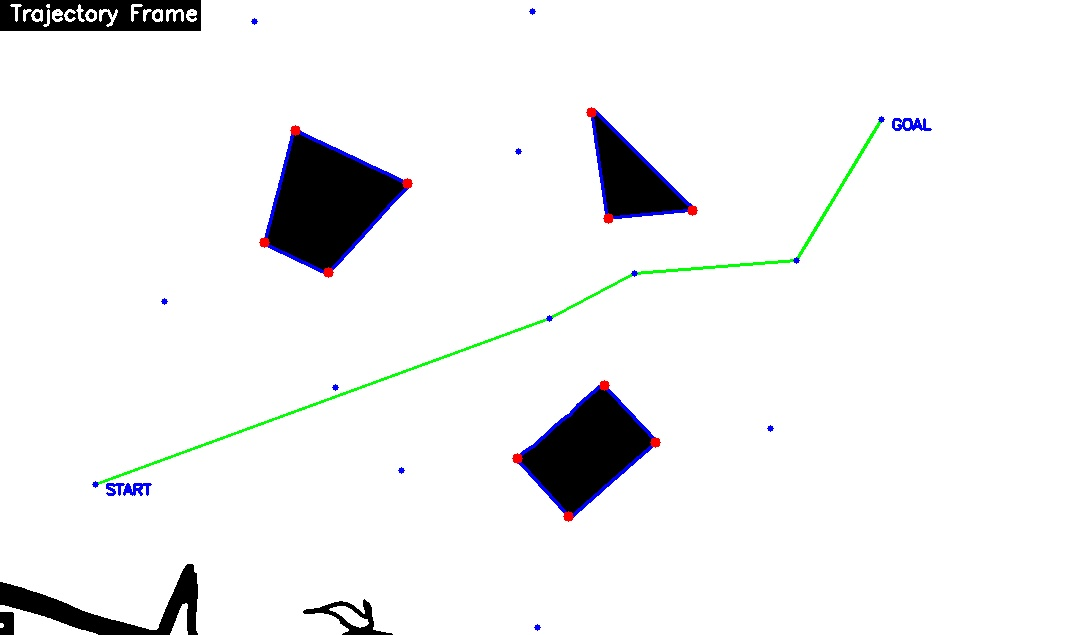

In [16]:
# Display variables
obstacles_img = None
trajectory_frame = None

# Positions variables
thymio_pos = None
goal_pos = None
trajectory_pos = None
obstacles_pos = None

# Flags variables
found_thymio = False
found_goal = False
found_trajectory = False

try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
    
    input("Press Enter to calculate the perspective vision...")
    
    # Get the perspective parameters for processing frame and return the scale factor for pixels to mm conversion
    vision.get_perspective_parameters(WORLD_WIDTH, WORLD_HEIGHT)
    
    # Display the original and processed frames
    original_frame, process_frame = vision.get_frame()
    utils.display_frames(original_frame, process_frame, None)
    
    input("Press Enter to get the obstacles position...")
    
    vision.flush()
    # Get the obstacles position
    _, process_frame = vision.get_frame()
    obstacles_pos, obstacles_img = vision.get_obstacles_position(process_frame)
    
    input("Press Enter when thymio and goal position have been placed on the map...")
    
    vision.flush()
    # Get the goal position and thymio position
    while not found_thymio:
        _, process_frame = vision.get_frame()
        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
        time.sleep(DT)
    
    print("Thymio detected!")
    print(f"Thymio position [mm]: {np.round(thymio_pos[:2], 1)}")
    print(f"Thymio orientation [°]: {np.degrees(thymio_pos[2])}")
    
    vision.flush()
    while not found_goal:
        _, process_frame = vision.get_frame()
        frame, goal_pos, found_goal = vision.get_goal_position(process_frame)
        time.sleep(DT)
    print("Goal detected!")
    print(f"Goal position [mm]: {np.round(goal_pos, 1)}")
    
    utils.display_frames(None, frame, None)
    
    input("Press Enter to get the trajectory from thymio to goal position...")
    
    vision.flush()
    # Get the trajectory from thymio to goal position
    while not found_trajectory:
        _, frame = vision.get_frame()
        trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, thymio_pos, goal_pos, obstacles_pos, 
                                                                                       THYMIO_WIDTH, vision.scale_factor)    
        time.sleep(DT)
         
    # Initialize the EKF
    ekf.initialize_state(np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2], 0.0, 0.0])) # x, y, theta, v, omega
    ekf.set_mode(covered=False) # Set the mode to uncovered
    
    utils.display_frames(None, frame, trajectory_frame)
    
    input("Press Enter to get overall information...")
    
except Exception as e:
    print(f"An error occurred: {str(e)}")
except KeyboardInterrupt:
    print("User interrupted the kernel. Closing the webcam...")

finally:
    # Release resources
    vision.disconnect_webcam()
    utils.print_status(obstacles_pos, thymio_pos, goal_pos, trajectory_pos)
    utils.display_frames(None, None, trajectory_frame)
    

Webcam disconnected correctly.
Finished at time [s]: 32.6
Camera coverage [%]: 5.521472392638037


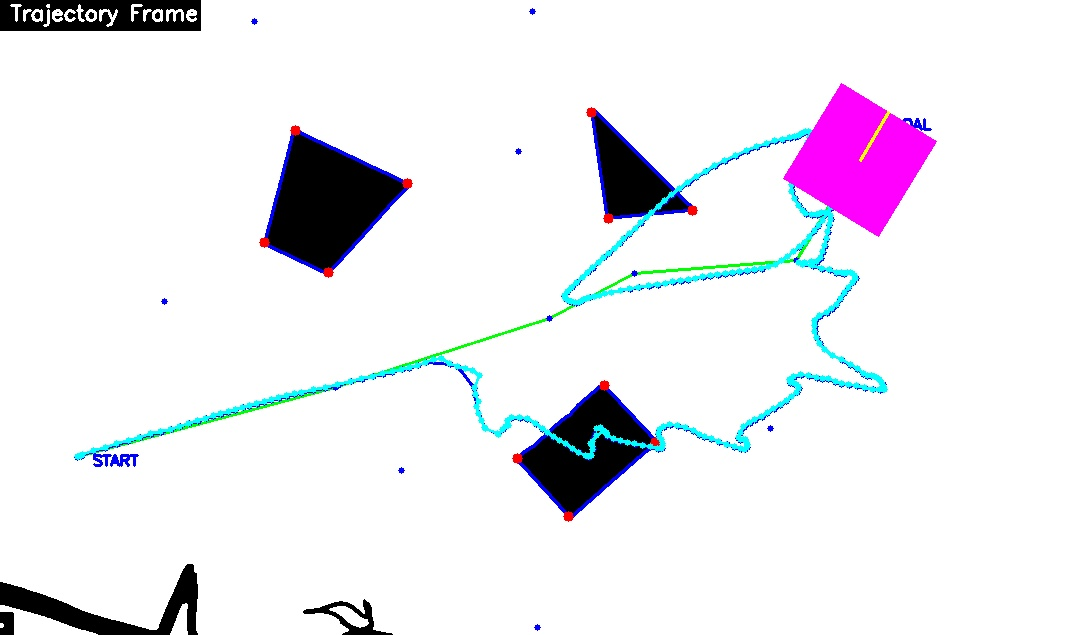

In [23]:
# Display variables
current_frame = None

# Positions variables
thymio_old_pos = thymio_pos
position_measured_history = []
filtered_position_history = [] 

# Flags variables
goal_reached = False

# Control variables
i = 0
covered = 0
left_speed = 0
right_speed = 0

try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
        
    input("Press Enter to start the navigation...")
    
    while not goal_reached:
        i += 1
        
        # Camera Measurement
        _, process_frame = vision.get_frame()
        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
        
        # Odometry Measurement
        left_measured_speed, right_measured_speed = get_speed()
        
        # EKF Prediction step with control inputs
        control_input = np.array([left_speed / SPEED_TO_MM_S, right_speed / SPEED_TO_MM_S])  
        ekf.predict(control_input)
        
        # Get current filtered state
        current_state, _ = ekf.get_state_and_covariance()

        if found_thymio:
            position_measured_history.append(thymio_pos[:2])
            
            # Use camera position and odometry for measurement
            measurement = np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2],
                                    left_measured_speed/SPEED_TO_MM_S, right_measured_speed/SPEED_TO_MM_S])
            
            if utils.distance(current_state[:2], thymio_old_pos[:2]) > KIDNAP_THRESHOLD:
                found_trajectory = False
                found_thymio = False
                local_nav.current_checkpoint = 1
                motor_stop()
                
                input("Kidnapped! Press Enter when Thymio has been placed elsewhere...")
                
                vision.flush()
                while not found_trajectory:
                    while not found_thymio:
                        _, process_frame = vision.get_frame()
                        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
                        time.sleep(DT)
                    print("Thymio detected!")
                    print(f"Thymio position [mm]: {np.round(thymio_pos[:2], 1)}")
                    print(f"Thymio orientation [°]: {np.degrees(thymio_pos[2])}")
                    
                    trajectory_frame = np.zeros_like(trajectory_frame)
                    trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, thymio_pos, goal_pos, obstacles_pos, 
                                                                                                   THYMIO_WIDTH, vision.scale_factor)
                    current_frame = trajectory_frame.copy()
                    current_frame = utils.draw_trajectory(current_frame, position_measured_history, 
                                                          vision.scale_factor, color=(255, 0, 0))

                    current_frame = utils.draw_trajectory(current_frame, filtered_position_history, 
                                                        vision.scale_factor, color=(0, 255, 0))
                    
                    current_frame = utils.draw_robot(current_frame, thymio_pos, THYMIO_WIDTH, 
                                                     THYMIO_LENGTH, vision.scale_factor)

                    time.sleep(DT)
                    
                # Reinitialize the EKF after kidnapping
                ekf.initialize_state(np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2], 0.0, 0.0]))
                local_nav.current_checkpoint = 0
                utils.display_frames(None, frame, current_frame)
                
                input("Press Enter to continue...")
                
        else: 
            covered += 1
            # Use filtered position when camera cannot see robot
            measurement = np.array([current_state[0], current_state[1], current_state[2],
                                    left_measured_speed/SPEED_TO_MM_S, right_measured_speed/SPEED_TO_MM_S])
            
        thymio_old_pos = current_state[:3]
        
        # Update EKF with appropriate mode
        ekf.set_mode(covered=(not found_thymio))
        ekf.update(measurement)
        
        # Use filtered state for navigation
        filtered_state, _ = ekf.get_state_and_covariance()
        filtered_position_history.append(filtered_state[:2])
        
        command, goal_reached = local_nav.get_command(trajectory_pos, filtered_state[:3], sensor_data())
        
        if (command['action'] == 'follow_path') or (command['action'] == 'avoid_obstacles'):
            if command['action'] == 'avoid_obstacles':
                print(left_speed, right_speed)
            left_speed = command['left_speed']
            right_speed = command['right_speed']
            set_speed(left_speed, right_speed)
        else:
            motor_stop()
            
        # Update trajectory frame with robot
        if trajectory_frame is not None:
            current_frame = trajectory_frame.copy()
            # Draw measured trajectory in blue
            current_frame = utils.draw_trajectory(current_frame, position_measured_history, 
                                                  vision.scale_factor, color=(255, 0, 0))
              # Draw filtered trajectory in green
            current_frame = utils.draw_trajectory(current_frame, filtered_position_history, 
                                                  vision.scale_factor, color=(255, 255, 0))
            # Draw robot using filtered position
            current_frame = utils.draw_robot(current_frame, filtered_state[:3], THYMIO_WIDTH, 
                                             THYMIO_LENGTH, vision.scale_factor)

        utils.display_frames(None, process_frame, current_frame) 
        time.sleep(DT)
        
# except Exception as e:
#     print(f"An error occurred: {str(e)}")
except KeyboardInterrupt:
    print("User interrupted the kernel. Shutting down the motors, closing the webcam...")
finally:
    # Release resources
    vision.disconnect_webcam()
    motor_stop()
    print("Finished at time [s]:", i * DT)
    print("Camera coverage [%]:", covered/i * 100)
    utils.display_frames(None, None, current_frame)
   

In [ ]:

await tdmclient.notebook.stop()
print("Successfully disconnected to Thymio.")

Successfully connected to Thymio.
